Minimal cost:  2.817428463884437


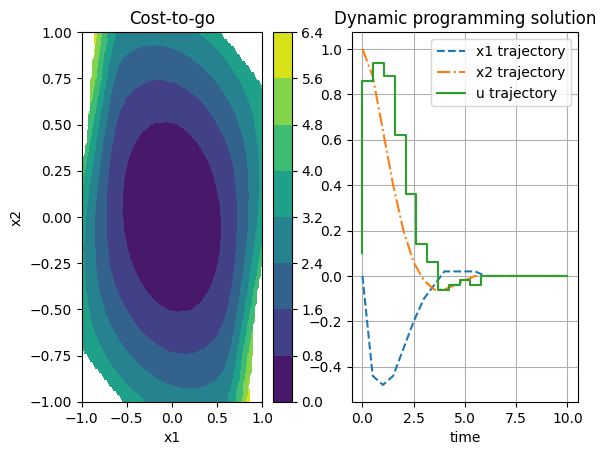

In [1]:
#
#     MIT No Attribution
#
#     Copyright (C) 2010-2023 Joel Andersson, Joris Gillis, Moritz Diehl, KU Leuven.
#
#     Permission is hereby granted, free of charge, to any person obtaining a copy of this
#     software and associated documentation files (the "Software"), to deal in the Software
#     without restriction, including without limitation the rights to use, copy, modify,
#     merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
#     INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
#     PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
#     HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
#     SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#

from pylab import *

# End time
T = 10.

# Number of control intervals
N = 20

# Number of Runge-Kutta 4 steps per interval and step size
NK = 20
DT = T/(N*NK)

# Number of discrete control values
NU = 101

# Number of discrete state values
NX = 101

# System dynamics, can be called with matricex
def f(x1,x2,u):
  x1_dot = (1 - x2*x2)*x1 - x2 + u
  x2_dot = x1
  q_dot  = x1*x1 + x2*x2 + u*u
  return (x1_dot, x2_dot, q_dot)

# Control enumeration
U  = linspace(-1,1,NU)

# State space enumeration
x1 = linspace(-1,1,NX)
x2 = linspace(-1,1,NX)
X1,X2 = meshgrid(x1,x2)

# For each control action and state, precalculate next state and stage cost
stage_J = []
next_x1 = []
next_x2 = []

for u in U:
  # Take number of integration steps
  X1_k = copy(X1)
  X2_k = copy(X2)
  Q_k = zeros(X1.shape)
  for k in range(NK):
    # RK4 integration for x1, x2 and q
    k1_x1, k1_x2, k1_q = f(X1_k,                X2_k,                u)
    k2_x1, k2_x2, k2_q = f(X1_k + DT/2 * k1_x1, X2_k + DT/2 * k1_x2, u)
    k3_x1, k3_x2, k3_q = f(X1_k + DT/2 * k2_x1, X2_k + DT/2 * k2_x2, u)
    k4_x1, k4_x2, k4_q = f(X1_k + DT   * k3_x1, X2_k + DT   * k3_x2, u)
    X1_k += DT/6*(k1_x1 + 2*k2_x1 + 2*k3_x1 + k4_x1)
    X2_k += DT/6*(k1_x2 + 2*k2_x2 + 2*k3_x2 + k4_x2)
    Q_k  += DT/6*(k1_q  + 2*k2_q  + 2*k3_q  + k4_q )

  # Find out which state comes next (index)
  X1_k = matrix.round((X1_k+1)/2*(NX-1)).astype(int)
  X2_k = matrix.round((X2_k+1)/2*(NX-1)).astype(int)

  # Infinite cost if state gets out-of-bounds
  I = X1_k  <  0; Q_k[I]=inf; X1_k[I]=0
  I = X2_k  <  0; Q_k[I]=inf; X2_k[I]=0
  I = X1_k >= NX; Q_k[I]=inf; X1_k[I]=0
  I = X2_k >= NX; Q_k[I]=inf; X2_k[I]=0

  # Save the stage cost and next state
  next_x1.append(X1_k)
  next_x2.append(X2_k)
  stage_J.append(Q_k)

# Calculate cost-to-go (no end cost) and optimal control
J = zeros(X1.shape)
U_opt = []
for k in reversed(list(range(N))):
  # Cost to go for the previous step, optimal control action
  J_prev = inf*ones(X1.shape)
  u_prev = -ones(X1.shape,dtype=int)

  # Test all control actions
  for uind in range(NU):
    J_prev_test = J[next_x2[uind],next_x1[uind]]+stage_J[uind]
    better = J_prev_test<J_prev
    u_prev[better] = uind
    J_prev[better] = J_prev_test[better]

  # Update cost-to-go and save optimal control
  J = J_prev
  U_opt.append(u_prev)

# Reorder U_opt by stage
U_opt.reverse()

# Find optimal control starting at x1=0, x2=1
i1 = NX//2
i2 = NX-1
u_opt = []
x1_opt = [x1[i1]]
x2_opt = [x2[i2]]
cost = 0
for k in range(N):
  # Get the optimal control and go to next step
  u_ind = U_opt[k][i2,i1]
  cost += stage_J[u_ind][i2,i1]
  i1, i2 = next_x1[u_ind][i2,i1], next_x2[u_ind][i2,i1]

  # Save the trajectories
  u_opt.append(U[u_ind])
  x1_opt.append(x1[i1])
  x2_opt.append(x2[i2])

# Optimal cost
print("Minimal cost: ", cost)
assert abs(cost-J[NX-1,NX//2])<1e-8 # Consistency check

# Plot
figure(1)
clf()

# Plot optimal cost-to-go
subplot(121)
contourf(X1,X2,J)
colorbar()
xlabel('x1')
ylabel('x2')
title('Cost-to-go')

subplot(122)
plot(linspace(0,T,N+1),x1_opt,'--')
plot(linspace(0,T,N+1),x2_opt,'-.')
step(linspace(0,T,N),u_opt,'-')
plt.title("Dynamic programming solution")
plt.xlabel('time')
plt.legend(['x1 trajectory','x2 trajectory','u trajectory'])
grid(True)
show()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      303
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality c

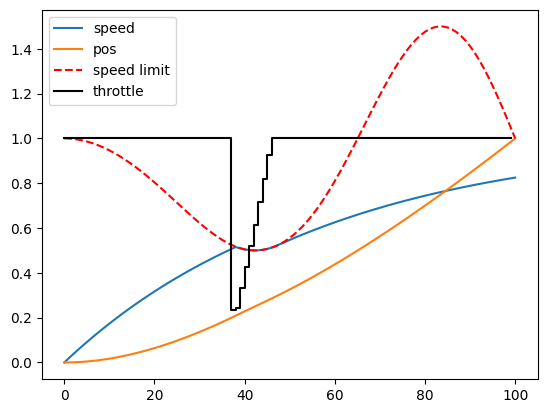

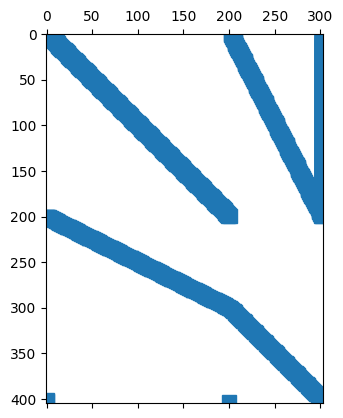

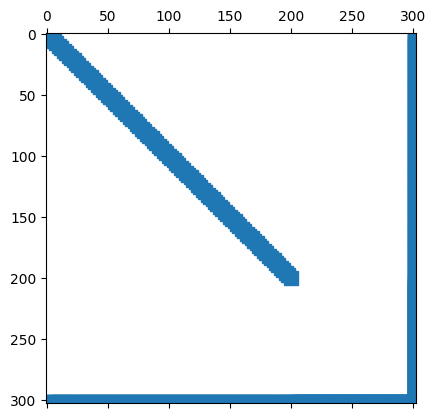

In [2]:
#
#     MIT No Attribution
#
#     Copyright (C) 2010-2023 Joel Andersson, Joris Gillis, Moritz Diehl, KU Leuven.
#
#     Permission is hereby granted, free of charge, to any person obtaining a copy of this
#     software and associated documentation files (the "Software"), to deal in the Software
#     without restriction, including without limitation the rights to use, copy, modify,
#     merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
#     INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
#     PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
#     HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
#     SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#

# Car race along a track
# ----------------------
# An optimal control problem (OCP),
# solved with direct multiple-shooting.
#
# For more information see: http://labs.casadi.org/OCP
from casadi import *

N = 100 # number of control intervals

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(2,N+1) # state trajectory
pos   = X[0,:]
speed = X[1,:]
U = opti.variable(1,N)   # control trajectory (throttle)
T = opti.variable()      # final time

# ---- objective          ---------
opti.minimize(T) # race in minimal time

# ---- dynamic constraints --------
f = lambda x,u: vertcat(x[1],u-x[1]) # dx/dt = f(x,u)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- path constraints -----------
limit = lambda pos: 1-sin(2*pi*pos)/2
opti.subject_to(speed<=limit(pos))   # track speed limit
opti.subject_to(opti.bounded(0,U,1)) # control is limited

# ---- boundary conditions --------
opti.subject_to(pos[0]==0)   # start at position 0 ...
opti.subject_to(speed[0]==0) # ... from stand-still 
opti.subject_to(pos[-1]==1)  # finish line at position 1

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

# ---- post-processing        ------
from pylab import plot, step, figure, legend, show, spy

plot(sol.value(speed),label="speed")
plot(sol.value(pos),label="pos")
plot(limit(sol.value(pos)),'r--',label="speed limit")
step(range(N),sol.value(U),'k',label="throttle")
legend(loc="upper left")

figure()
spy(sol.value(jacobian(opti.g,opti.x)))
figure()
spy(sol.value(hessian(opti.f+dot(opti.lam_g,opti.g),opti.x)[0]))

show()

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 1.3450462       18 0.145
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 1.3450462       10 0.083
NLP0014I             2         OPT 1.3450462       10 0.089
NLP0014I             3         OPT 1.3450462       10 0.076
NLP0014I             4         OPT 1.3450462        9 0.062
NLP0014I             5         OPT 1.3450462        9 0.069
NLP0014I             6         OPT 1.3450462        8 0.068
NLP0014I             7         OPT 1.3450463        8 0.065
NLP0014I             8         OPT 1.3450463        6 0.056
NLP0014I             9         OPT 1.3450467        6 0.051
NLP0014I            10         OPT 1.3450468        8 0.064
NLP0014I            11         OPT 1.3450469       10 0.085
NLP0014I            12         OPT 1.34505       11 0.09
NLP0014I            13 

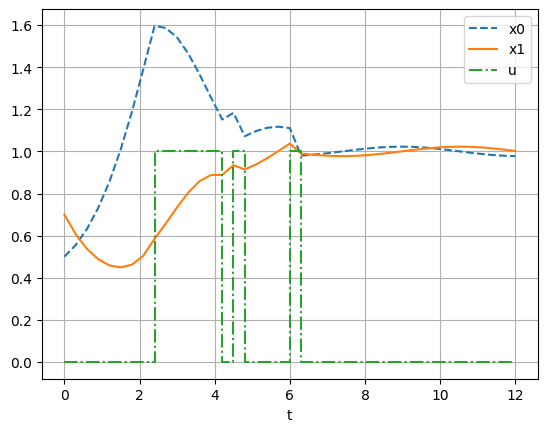

In [3]:
#
#     MIT No Attribution
#
#     Copyright (C) 2010-2023 Joel Andersson, Joris Gillis, Moritz Diehl, KU Leuven.
#
#     Permission is hereby granted, free of charge, to any person obtaining a copy of this
#     software and associated documentation files (the "Software"), to deal in the Software
#     without restriction, including without limitation the rights to use, copy, modify,
#     merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
#     INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
#     PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
#     HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
#     SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#
from casadi import *

# Lotka-Volerra problem from mintoc.de

T = 12. # Time horizon
N = 40 # number of control intervals

# Model parameters
c0 = .4
c1 = .2

# Initial condition for x
x0 = [0.5, 0.7]

# Bounds on x
lbx = [0., 0.]
ubx = [2., 2.]

# Bounds on u
lbu = 0.
ubu = 1.

# Declare model variables
x = SX.sym('x', 2)
u = SX.sym('u')

# Model equations
xdot = vertcat(x[0] - x[0] * x[1] - c0 * x[0] * u,
              -x[1] + x[0] * x[1] - c1 * x[1] * u)

# Objective term
L = (x[0] - 1)**2 + (x[1] - 1)**2 + 1e-4*u**2

# Formulate discrete time dynamics
if False:
   # CVODES from the SUNDIALS suite
   dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
   F = integrator('F', 'cvodes', dae, 0, T/N)
else:
   # Fixed step Runge-Kutta 4 integrator
   M = 4 # RK4 steps per interval
   DT = T/N/M
   f = Function('f', [x, u], [xdot, L])
   X0 = MX.sym('X0', 2)
   U = MX.sym('U')
   X = X0
   Q = 0
   for j in range(M):
       k1, k1_q = f(X, U)
       k2, k2_q = f(X + DT/2 * k1, U)
       k3, k3_q = f(X + DT/2 * k2, U)
       k4, k4_q = f(X + DT * k3, U)
       X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
       Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
   F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])

# Initial guess for u
u_start = [DM(0.)] * N

# Get a feasible trajectory as an initial guess
xk = DM(x0)
x_start = [xk]
for k in range(N):
    xk = F(x0=xk, p=u_start[k])['xf']
    x_start += [xk]

# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
discrete = []
J = 0
g=[]
lbg = []
ubg = []

# "Lift" initial conditions
X0 = MX.sym('X0', 2)
w += [X0]
lbw += x0
ubw += x0
w0 += [x_start[0]]
discrete += [False, False]

# Formulate the NLP
Xk = X0
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    w   += [Uk]
    lbw += [lbu]
    ubw += [ubu]
    w0  += [u_start[k]]
    discrete += [True]

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk_end = Fk['xf']
    J=J+Fk['qf']

    # New NLP variable for state at end of interval
    Xk = MX.sym('X_' + str(k+1), 2)
    w   += [Xk]
    lbw += lbx
    ubw += ubx
    w0  += [x_start[k+1]]
    discrete += [False, False]

    # Add equality constraint
    g   += [Xk_end-Xk]
    lbg += [0, 0]
    ubg += [0, 0]

# Concatenate decision variables and constraint terms
w = vertcat(*w)
g = vertcat(*g)

# Create an NLP solver
nlp_prob = {'f': J, 'x': w, 'g': g}
nlp_solver = nlpsol('nlp_solver', 'bonmin', nlp_prob, {"discrete": discrete});
#nlp_solver = nlpsol('nlp_solver', 'knitro', nlp_prob, {"discrete": discrete});
#nlp_solver = nlpsol('nlp_solver', 'ipopt', nlp_prob); # Solve relaxed problem

# Plot the solution
tgrid = [T/N*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
def plot_sol(w_opt):
    w_opt = w_opt.full().flatten()
    x0_opt = w_opt[0::3]
    x1_opt = w_opt[1::3]
    u_opt = w_opt[2::3]
    plt.plot(tgrid, x0_opt, '--')
    plt.plot(tgrid, x1_opt, '-')
    plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
    plt.xlabel('t')
    plt.legend(['x0','x1','u'])
    plt.grid(True)

# Solve the NLP
sol = nlp_solver(x0=vertcat(*w0), lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

print(nlp_solver.stats())

w1_opt = sol['x']
lam_w_opt = sol['lam_x']
lam_g_opt = sol['lam_g']
plot_sol(w1_opt)

plt.show()

In [2]:
import casadi

def f(x):
    return x**2

def h(x):
    return x**3

opti = casadi.Opti()

x = 2
y = 2
y_hat = 2
q = opti.variable()

x_dot = f(x)
y_dot = h(x) - y_hat
q_dot = y_dot - y


opti.minimize( q_dot )
#opti.subject_to( x**2+y**2==1 )
#opti.subject_to(       x+y>=1 )

opti.solver('ipopt')

sol = opti.solve()

print(sol.value(x))
print(sol.value(y))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        0
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c